In [1]:
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
schools_data = dict(J=8, 
                    y=[28,  8, -3,  7, -1,  1, 18, 12],
                    sigma=[15, 10, 16, 11,  9, 11, 10, 18])

In [3]:
print(pd.DataFrame({'y': schools_data['y'],
              'sigma': schools_data['sigma']}, 
             index=['School {}'.format(i + 1) for i in range(8)])[['y', 'sigma']])

           y  sigma
School 1  28     15
School 2   8     10
School 3  -3     16
School 4   7     11
School 5  -1      9
School 6   1     11
School 7  18     10
School 8  12     18


In [4]:
complete_pooling_code = """
data {
  int<lower=0> J; // number of schools 
  real y[J]; // estimated treatment effects
  real<lower=0> sigma[J]; // s.e. of effect estimates 
}
parameters {
  real school_effect;
}
model {
  y ~ normal(school_effect, sigma);
}
"""

complete_pooling = pystan.StanModel(model_code=complete_pooling_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7394647b92199576830f927dd84b72f NOW.


In [5]:
complete_pooling_fit = complete_pooling.sampling(data=schools_data)

In [6]:
print(complete_pooling_fit)

Inference for Stan model: anon_model_b7394647b92199576830f927dd84b72f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
school_effect   7.76     0.1   4.04  -0.28   5.08   7.74  10.45  15.75 1523.0    1.0
lp__           -2.85    0.02   0.72  -4.86   -3.0  -2.57   -2.4  -2.35 1298.0    1.0

Samples were drawn using NUTS at Thu Aug 30 16:22:02 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


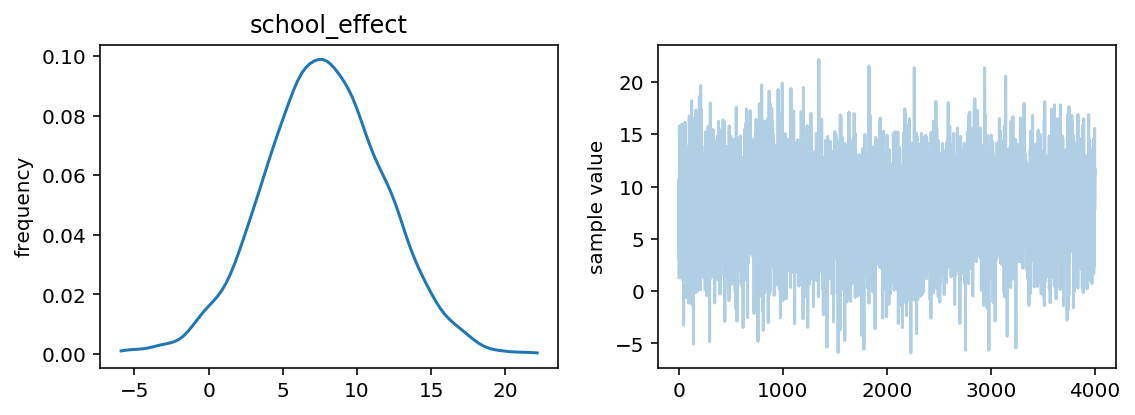

In [7]:
f = complete_pooling_fit.plot()
f.set_size_inches(8, 3)
f.tight_layout()

In [8]:
partial_pooling_code = """
data {
  int<lower=0> J; // number of schools 
  real y[J]; // estimated treatment effects
  real<lower=0> sigma[J]; // s.e. of effect estimates 
}
parameters {
  real mu; 
  real<lower=0> tau;
  vector[J] school_effects;
}
model {
  school_effects ~ normal(mu, tau);
  y ~ normal(school_effects, sigma);
}
"""

partial_pooling = pystan.StanModel(model_code=partial_pooling_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68df37c92d05889cf3271ff3c886a272 NOW.


In [57]:
partial_pooling_fit = partial_pooling.sampling(data=schools_data)

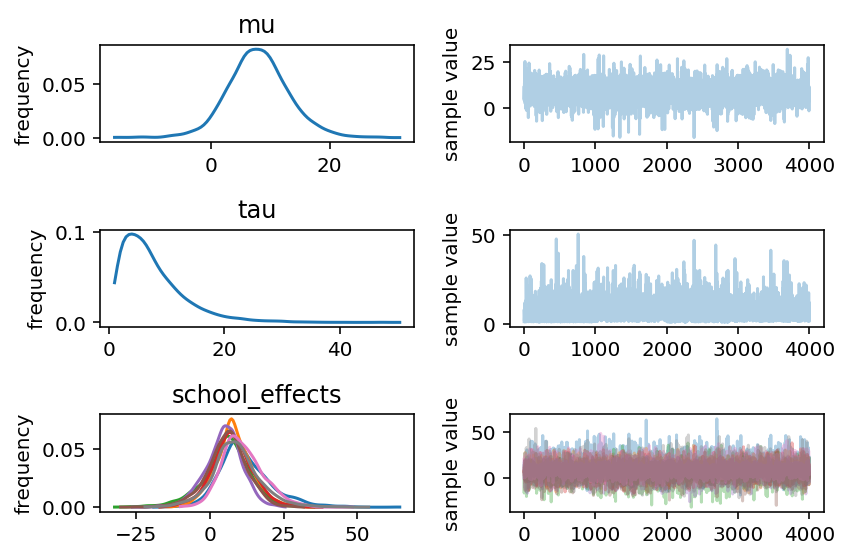

In [58]:
f = partial_pooling_fit.plot()
f.tight_layout()

In [59]:
print(partial_pooling_fit)

Inference for Stan model: anon_model_68df37c92d05889cf3271ff3c886a272.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                  7.98    0.17   5.24  -2.25   4.73   7.88  11.09  18.81  938.0    1.0
tau                 7.65    0.29   5.56   1.44   3.71   6.27  10.06  22.39  372.0   1.02
school_effects[0]  11.97     0.3   8.94  -2.87   6.25  10.58  16.68  32.69  888.0   1.01
school_effects[1]   7.95    0.14   6.45  -4.85   4.07   7.68  11.87  21.92 2258.0    1.0
school_effects[2]   5.68     0.2   8.12 -12.55   1.49    6.1  10.59  20.76 1701.0    1.0
school_effects[3]    7.6    0.15   6.97  -6.55    3.3   7.27  11.84  21.89 2092.0    1.0
school_effects[4]   4.69    0.18   6.36  -8.83    1.0   5.08   8.67   16.4 1319.0    1.0
school_effects[5]   5.82    0.18    7.0  -9.21   1.82   6.19  10.17  18.81 1556.0    1.0
school_eff

In [60]:
from tpr.models.utils import summarise_posteriors

In [61]:
results = partial_pooling_fit.extract()
p_pooling = results
school_df = pd.DataFrame(results['school_effects'], 
                         columns=['School {}'.format(i + 1) for i in range(8)])

summarise_posteriors(school_df).astype(int)

,2.5%,25%,median,75%,97.5%
School 1,-2,6,10,16,32
School 2,-4,4,7,11,21
School 3,-12,1,6,10,20
School 4,-6,3,7,11,21
School 5,-8,0,5,8,16
School 6,-9,1,6,10,18
School 7,0,6,10,15,26
School 8,-7,3,8,13,26


Text(0.5,1,u'Partial pooling and complete pooling mean')

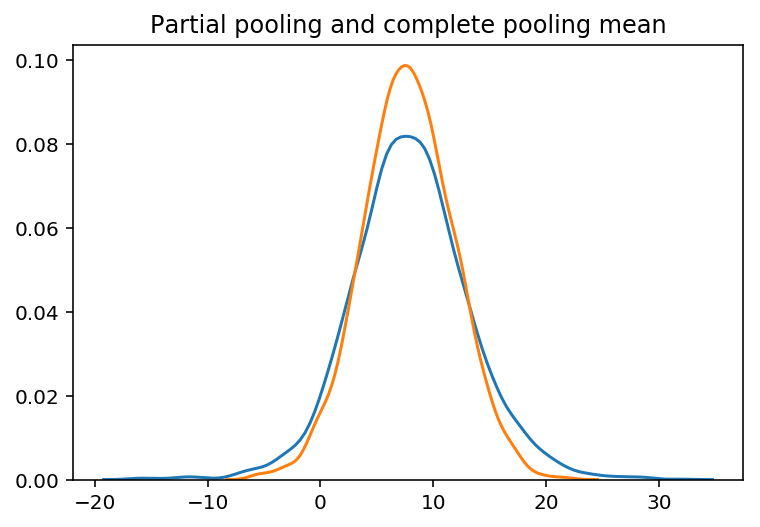

In [62]:
# Compare complete pooling with partial pooling
# Pretty similar!
mu_partial = partial_pooling_fit['mu']
std_partial = partial_pooling_fit['tau']

sns.kdeplot(mu_partial)
sns.kdeplot(complete_pooling_fit['school_effect'])

plt.title('Partial pooling and complete pooling mean')

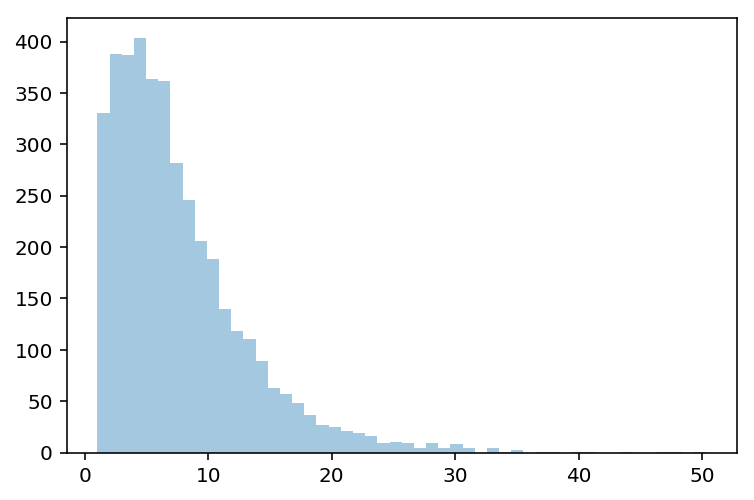

In [63]:
# But now we also have variation in the treatment effect across schools:
sns.distplot(std_partial, kde=False)

Text(0.5,1,u'Shrinkage')

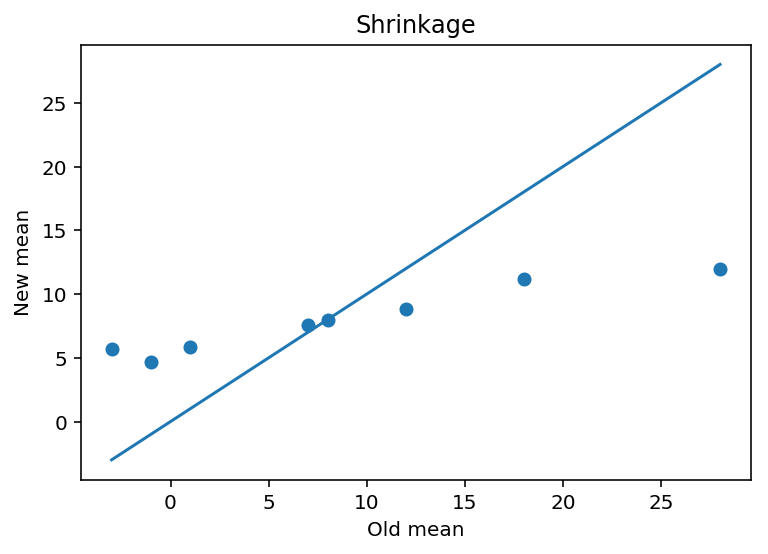

In [64]:
revised_means = partial_pooling_fit['school_effects'].mean(axis=0)
old_means = np.array(schools_data['y'])

plt.scatter(old_means, revised_means)
plt.plot([old_means.min(), old_means.max()], [old_means.min(), old_means.max()])
plt.xlabel('Old mean')
plt.ylabel('New mean')
plt.title('Shrinkage')

In [17]:
no_pooling_code = """
data {
  int<lower=0> J; // number of schools 
  real y[J]; // estimated treatment effects
  real<lower=0> sigma[J]; // s.e. of effect estimates 
}
parameters {
  vector[J] school_effects;
}
model {
  y ~ normal(school_effects, sigma);
}
"""

no_pooling = pystan.StanModel(model_code=no_pooling_code)
no_pooling_fit = no_pooling.sampling(data=schools_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fa3554fd5cc9a383ed9750398c84b6f NOW.


In [22]:
results = no_pooling_fit.extract()
no_pooling = results

school_df = pd.DataFrame(results['school_effects'], 
                         columns=['School {}'.format(i + 1) for i in range(8)])

summarise_posteriors(school_df).astype(int)

,2.5%,25%,median,75%,97.5%
School 1,-1,17,27,37,57
School 2,-12,1,8,14,27
School 3,-34,-13,-2,7,29
School 4,-14,0,7,14,27
School 5,-18,-6,0,4,16
School 6,-21,-6,0,8,23
School 7,-1,11,17,24,37
School 8,-23,0,11,24,48


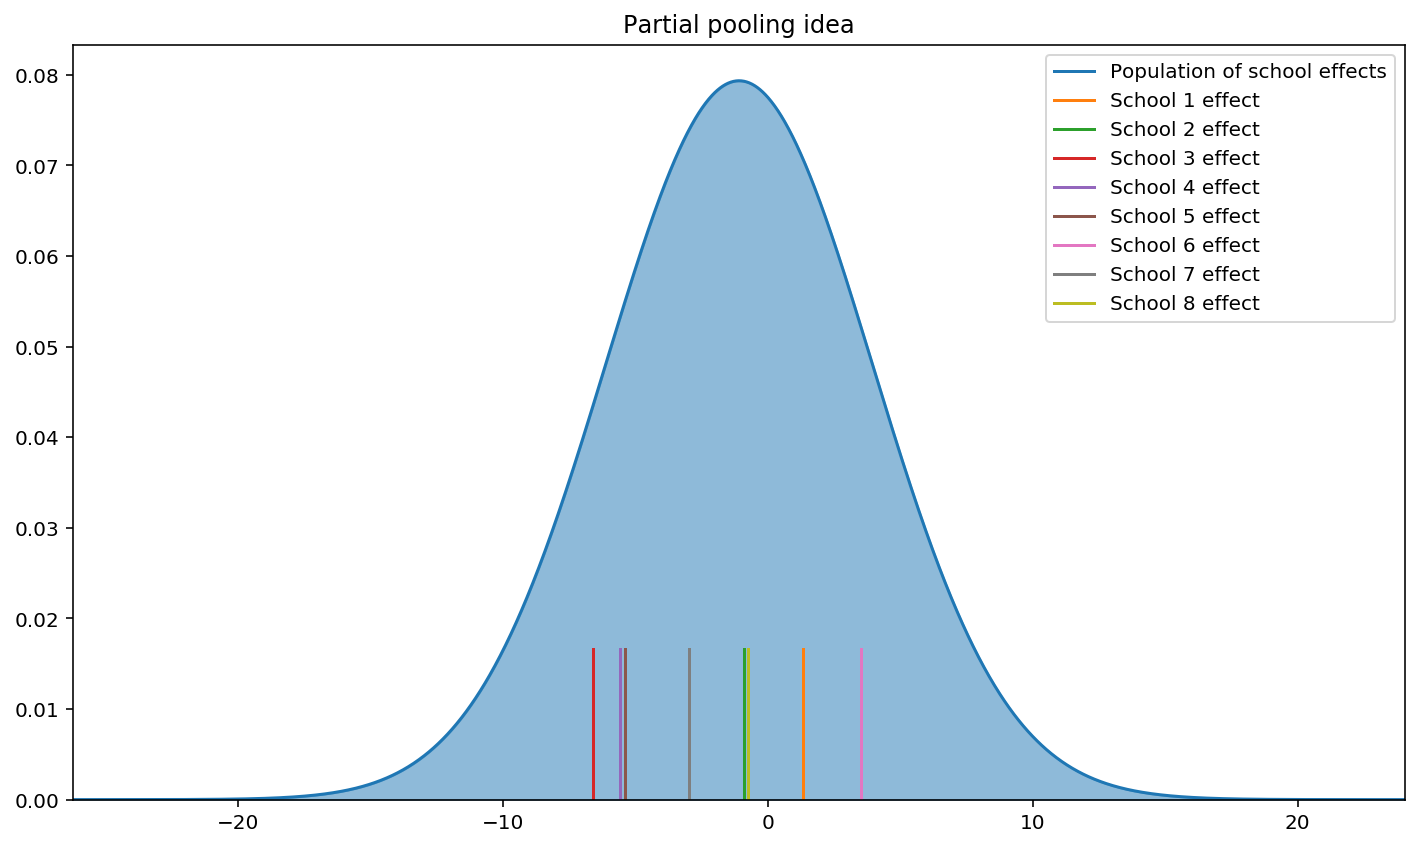

In [56]:
from scipy.stats import norm

f, ax = plt.subplots(1, 1)

realisation = 45

# Hierarchical example overview
# Population distribution
pop_mu = mu_partial[realisation]
pop_sd = std_partial[realisation]

# Mean school effects
cur_school_effects = p_pooling['school_effects'][realisation, :]

colours = sns.color_palette(n_colors=9)

lower = pop_mu - 5 * pop_sd
upper = pop_mu + 5 * pop_sd

values = np.linspace(lower, upper, 2000)
density = norm.pdf(values, pop_mu, pop_sd)
ax.plot(values, density, label='Population of school effects', color=colours[0])
ax.fill_between(values, 0, density, alpha=0.5, color=colours[0])

for i, cur_mean in enumerate(cur_school_effects):
    ax.axvline(cur_mean, label='School {} effect'.format(i + 1), color=colours[i + 1], ymin=0., ymax=0.2)
    
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(lower, upper)

f.set_size_inches(10, 6)
plt.title('Partial pooling idea')
f.tight_layout()

#plt.savefig('../talks/august_2018_example_models/partial_pooling.png', dpi=300)

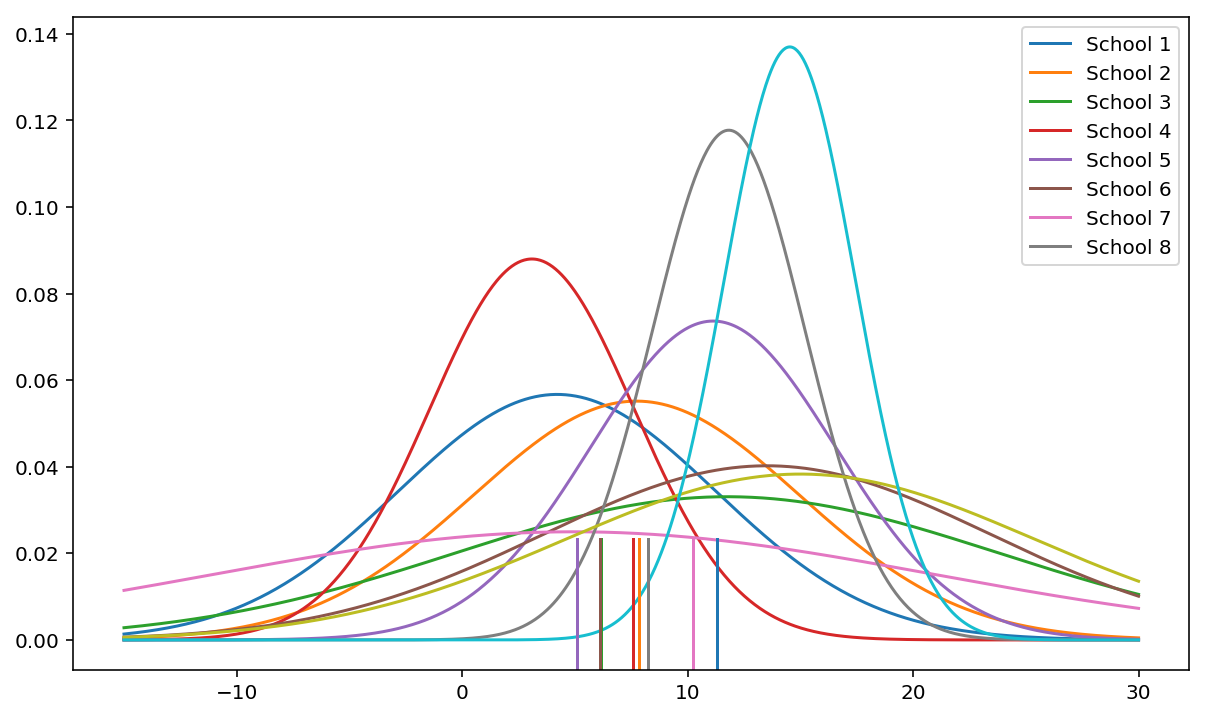

In [30]:
from scipy.stats import norm

f, ax = plt.subplots(1, 1)

# Hierarchical example overview
# Population distribution
mean_mu = mu_partial.mean()
mean_sd = std_partial.mean()

# Mean school effects
school_means = p_pooling['school_effects'].mean(axis=0)

values = np.linspace(-15, 30, 1000)

for i, (cur_mu, cur_sd) in enumerate(zip(mu_partial, std_partial)):
    if i % 400 == 0:
        density = norm.pdf(values, cur_mu, cur_sd)
        ax.plot(values, density)

colours = sns.color_palette(n_colors=8)

for i, cur_mean in enumerate(school_means):
    ax.axvline(cur_mean, label='School {}'.format(i + 1), color=colours[i], ymin=0., ymax=0.2)
    
ax.legend()

f.set_size_inches(10, 6)